# Deep Matching

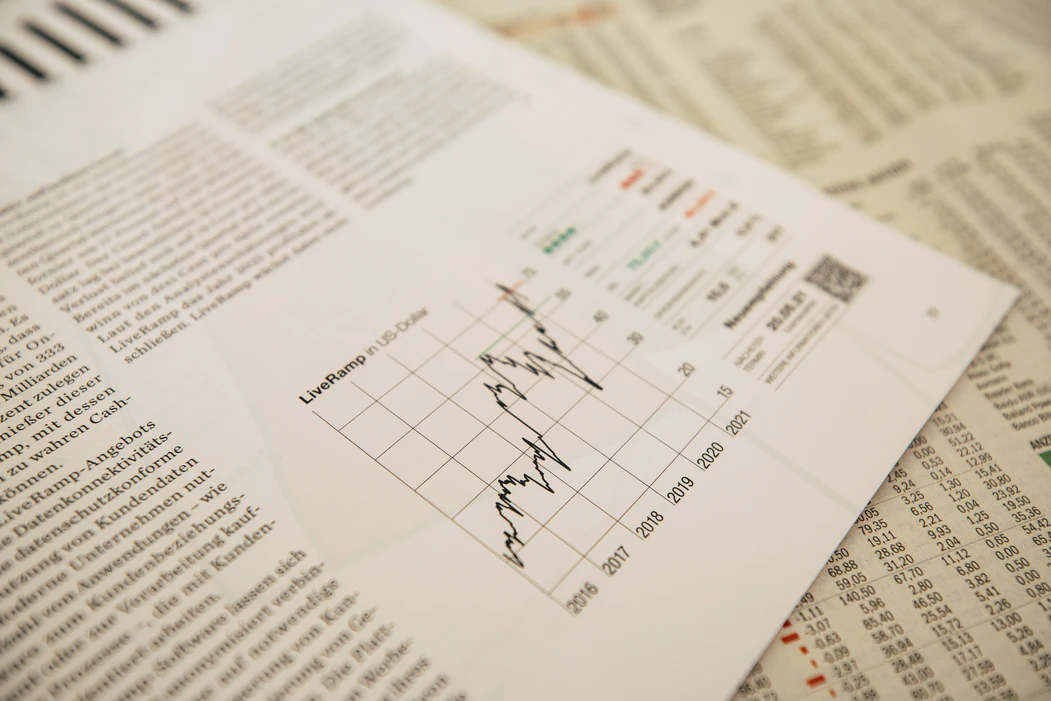

In [62]:
import csv 
import json
import string
import random
import typing

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
import keras
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# python3 -m spacy download en_core_web_sm
english: spacy.lang.en.English = spacy.load("en_core_web_sm")
    
np.random.seed(5)

In [3]:
def random_string(size: int = 10) -> str:
    """
    Generates a random string.
    """
    chars: str = string.ascii_lowercase + "aeiou" * 30 + "rtsmpcnlgr" * 15
    return "".join([
        random.choice(chars)
        for _ in range(size)
    ])

assert isinstance(random_string(), str)
assert random_string() != random_string()
assert len(random_string(10)) == 10
assert len(random_string(20)) == 20

In [4]:
def random_integer(low: int = 0, high: int = 100) -> int:
    """
    Generates a random integer.
    """
    return random.randint(low, high)

assert isinstance(random_integer(), int)
assert random_integer() >= 0
assert random_integer() <= 100
assert random_integer(low=120, high=140) >= 120
assert random_integer(low=120, high=140) <= 140

In [5]:
def random_float(low: int = 0, high: int = 100) -> float:
    """
    Generates a random float number.
    """
    return random.uniform(low, high)

assert isinstance(random_float(), float)
assert random_float() >= 0
assert random_float() <= 100
assert random_float(low=120, high=140) <= 140
assert random_float(low=120, high=140) >= 120

In [6]:
def random_probability() -> float:
    """
    Generates a random probability float number.
    """
    return random.uniform(0, 1)

assert isinstance(random_probability(), float)
assert random_probability() >= 0
assert random_probability() <= 1

In [7]:
def random_event(probability: float = 0.5) -> bool:
    """
    Generates a determines the occurrence of a random event.
    """
    assert probability >= 0
    assert probability <= 1
    return random_probability() < probability

assert isinstance(random_event(), bool)
assert random_event(probability=1) is True
assert random_event(probability=0) is False

In [8]:
def random_option(options: list) -> str:
    """
    Selects a value from a list randomly.
    """
    return random.choice(list(set(options)))

assert random_option([1, 2, 3]) in [1, 2, 3]

In [9]:
def random_phone() -> str:
    """
    Generates a random phone number.
    """
    return "-".join(
        [
            str(random_integer(100, 999)),
            str(random_integer(100, 999)),
            str(random_integer(1000, 9999)),
        ]
    )

assert isinstance(random_phone(), str)
assert random_phone() != random_phone()

In [10]:
def random_name() -> str:
    """
    Generates a random name.
    """
    return " ".join(
        [
            random_string(random_integer(8, 12)),
            random_string(random_integer(8, 12)),
        ]
    ).title()

assert isinstance(random_name(), str)
assert random_name() != random_name()

In [11]:
def random_city() -> str:
    """
    Generates a random city name.
    """
    return "".join(
        [
            random_string(random_integer(3, 6)),
            random_option([" ", ""]),
            random_string(random_integer(3, 6)),
        ]
    ).title()

assert isinstance(random_city(), str)
assert random_city() != random_city()

In [12]:
def random_website() -> str:
    """
    Generates a random website.
    """
    return ".".join(
        [
            "www",
            random_string(random_integer(7, 15)),
            random_option(["com", "net", "org"]),
        ]
    ).lower()

assert isinstance(random_website(), str)
assert random_website() != random_website()

In [13]:
def random_linkedin_url() -> str:
    """
    Generates a random LinkedIn URL.
    """
    return "/".join(
        [
            "www.linkedin.com",
            "u",
            random_string(random_integer(8, 15)),
        ]
    ).lower()

assert isinstance(random_linkedin_url(), str)
assert random_linkedin_url() != random_linkedin_url()

In [14]:
def random_facebook_url() -> str:
    """
    Generates a random Facebook URL.
    """
    return "/".join(
        [
            "https://",
            "www.facebook.com",
            "profile",
            random_string(random_integer(8, 15)),
        ]
    ).lower()

assert isinstance(random_facebook_url(), str)
assert random_facebook_url() != random_facebook_url()

In [15]:
def random_country() -> str:
    """
    Generates a random country.
    """
    return "".join(
        [
            random_string(random_integer(3, 6)),
            random_option([" ", ""]),
            random_string(random_integer(3, 6)),
        ]
    ).title()

assert isinstance(random_country(), str)
assert random_country() != random_country()

In [16]:
def random_street() -> str:
    """
    Generates a random street address.
    """
    return " ".join(
        [
            str(random_integer(1, 999)),
            random_string(random_integer(3, 8)),
            random_string(random_integer(4, 6)) + ",",
            random_string(random_integer(4, 6)),
            random_option(["St.", "Av."]),
        ]
    ).title()

assert isinstance(random_street(), str)
assert random_street() != random_street()

In [17]:
def similar_string(value: str, mutability: float = 0.2) -> str:
    """
    Generates a random string similar to a given string.
    """
    new_value: list = list(value)
    for i in range(len(new_value)):
        if random_event(mutability):
            new_value[i] = random_string(1)
    if new_value and random_event(mutability):
        new_value.pop(-1)
    if new_value and random_event(mutability):
        new_value.append(random_string(1))
    if not new_value and random_event(mutability):
        new_value: str = random_string(random_integer(4, 12))
    return "".join(new_value)

assert isinstance(similar_string("a", mutability=0.5), str)
assert similar_string("a", mutability=0.0) == "a"
assert similar_string("a", mutability=1.0) != "a"
assert similar_string("aaaaaa", mutability=1.0) != similar_string("aaaaaa", mutability=1)

In [18]:
def similar_dict(record: dict, mutability: float = 0.1) -> dict:
    """
    Generates a random dictionary similar to a given dictionary.
    """
    other: dict = {}
    for k, v in record.items():
        if isinstance(v, str):
            other[k] = similar_string(value=v, mutability=mutability)
        else:
            other[k] = v
    return other

assert isinstance(similar_dict({"a": "b"}, mutability=0.5), dict)
assert similar_dict({"a": "b"}, mutability=0.0) == {"a": "b"}
assert similar_dict({"a": "b"}, mutability=1.0) != {"a": "b"}

In [19]:
def random_company(nulls: float = 0.1) -> dict:
    """
    Generates a random dictionary representation of a company.
    """
    return {
        "city": "" if random_event(probability=nulls) else random_city(),
        "country": "" if random_event(probability=nulls) else random_country(),
        "company_name": random_name(),
        "phone": "" if random_event(probability=nulls) else random_phone(),
        "street_address": "" if random_event(probability=nulls) else random_street(),
        "website": "" if random_event(probability=nulls) else random_website(),
        "linkedin_url": "" if random_event(probability=nulls) else random_linkedin_url(),
        "facebook_url": "" if random_event(probability=nulls) else random_facebook_url(),
    }

assert isinstance(random_company(), dict)
assert all(isinstance(k, str) for k in random_company().keys())
assert all(isinstance(v, str) for v in random_company().values())

In [20]:
def random_person(nulls: float = 0.1) -> dict:
    """
    Generates a random representation of a person.
    """
    return {
        "city": "" if random_event(probability=nulls) else random_city(),
        "country": "" if random_event(probability=nulls) else random_country(),
        "name": random_name(),
        "phone": "" if random_event(probability=nulls) else random_phone(),
        "street_address": "" if random_event(probability=nulls) else random_street(),
        "linkedin_url": "" if random_event(probability=nulls) else random_linkedin_url(),
        "facebook_url": "" if random_event(probability=nulls) else random_facebook_url(),
    }

assert isinstance(random_person(), dict)
assert all(isinstance(k, str) for k in random_person().keys())
assert all(isinstance(v, str) for v in random_person().values())

In [21]:
def add_suffix(record: dict, suffix: str) -> dict:
    """
    Appends a suffix to all the keys of a given dictionary.
    """
    return {f"{k}#{suffix}": v for k, v in record.items()}

assert add_suffix({"a": "b"}, "1") == {"a#1": "b"}
assert add_suffix({"a": "b"}, "2") == {"a#2": "b"}

In [22]:
def word2vec(text: typing.Optional[str]) -> np.ndarray:
    """
    Transforms a string into a numpy array of a fixed size.
    """
    if not isinstance(text, str) or text == "":
        return np.zeros(96)
    return english(text).vector

assert isinstance(word2vec("lorem"), np.ndarray)
assert np.array_equal(word2vec("lorem"), word2vec("lorem"))
assert word2vec("lorem").shape == (96, )
assert isinstance(word2vec(""), np.ndarray)
assert np.array_equal(word2vec(""), word2vec(""))
assert word2vec("").shape == (96, )

In [23]:
def df2vec(dataset: pd.DataFrame, target: str = 'match') -> pd.DataFrame:
    """
    Transforms a string into a numpy array of a fixed size.
    """
    vectorized_dataset: pd.DataFrame = dataset.copy()  
    for feature in vectorized_dataset.columns:
        print("Vectorizing:", feature)
        if feature != target:
            vectorized_dataset[feature] = vectorized_dataset[feature].apply(word2vec).apply(np.array)
    return vectorized_dataset

assert isinstance(df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
)['a'][0], np.ndarray)
assert isinstance(df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
)['a'][1], np.ndarray)
assert df2vec(
    pd.DataFrame({"a": ["b", "c"], "t": [0, 1]}), target="t",
).shape == (2, 2)

Vectorizing: a
Vectorizing: t
Vectorizing: a
Vectorizing: t
Vectorizing: a
Vectorizing: t


Companies: (1, 17)
Companies: (1, 17)
Companies: (1, 17)
Companies: (1, 17)
Companies: (2, 17)


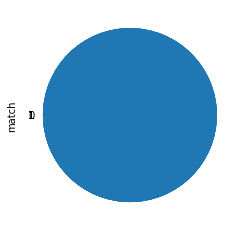

In [24]:
def generate_random_companies(
    total: int = 1000,
    target: str = 'match',
    matches: float = 0.5,
    nulls: float = 0.1,
    mutability: float = 0.01,
    feedback: list = None,
) -> pd.DataFrame:
    """
    Generates a random dataset of $total companies.
    """
    raw_companies_list: typing.List[dict] = []
    for _ in range(total):
        company1: dict = random_company(nulls=nulls)
        if random_event(probability=matches):
            company2: dict = similar_dict(company1, mutability=mutability)
            match: str = "1" 
        else:
            company2: dict = random_company(nulls=0.1)
            match: str = "0" 
        row: dict = {}
        for k, v in add_suffix(company1, "1").items():
            row[k] = v 
        for k, v in add_suffix(company2, "2").items():
            row[k] = v 
        raw_companies_list.append({
            **add_suffix(company1, "1"),
            **add_suffix(company2, "2"),
            target: match,
        })
    if feedback is not None:
        for case in feedback:
            raw_companies_list.insert(0, {
                **add_suffix(case[0], "1"),
                **add_suffix(case[1], "2"),
                target: case[2],                
            })
    raw_companies_dataframe: pd.DataFrame = pd.DataFrame(raw_companies_list)
    raw_companies_dataframe[target] = raw_companies_dataframe[target].astype(int)
    print("Companies:", raw_companies_dataframe.shape)
    raw_companies_dataframe[target].astype(int).value_counts().plot(kind='pie')
    return raw_companies_dataframe

assert isinstance(generate_random_companies(total=1), pd.DataFrame)
assert not generate_random_companies(total=1).equals(generate_random_companies(total=1))
assert generate_random_companies(total=1).shape == (1, 17)
assert generate_random_companies(total=2).shape == (2, 17)

Persons: (1, 15)
Persons: (1, 15)
Persons: (1, 15)
Persons: (1, 15)
Persons: (2, 15)


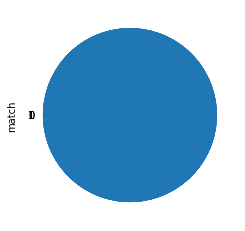

In [25]:
def generate_random_persons(
    total: int = 1000,
    target: str = 'match',
    matches: float = 0.5,
    nulls: float = 0.1,
    mutability: float = 0.01,
    feedback: list = None,
) -> pd.DataFrame:
    """
    Generates a random dataset of $total persons.
    """
    raw_persons_list: typing.List[dict] = []
    for _ in range(total):
        person1: dict = random_person(nulls=nulls)
        if random_event(probability=matches):
            person2: dict = similar_dict(person1, mutability=mutability)
            match: str = "1" 
        else:
            person2: dict = random_person(nulls=0.1)
            match: str = "0" 
        row: dict = {}
        for k, v in add_suffix(person1, "1").items():
            row[k] = v 
        for k, v in add_suffix(person2, "2").items():
            row[k] = v 
        raw_persons_list.append({
            **add_suffix(person1, "1"),
            **add_suffix(person2, "2"),
            target: match,
        })
    if feedback is not None:
        for case in feedback:
            raw_persons_list.append({
                **add_suffix(case[0], "1"),
                **add_suffix(case[1], "2"),
                target: case[2], 
            })
    raw_persons_dataframe: pd.DataFrame = pd.DataFrame(raw_persons_list)
    raw_persons_dataframe[target] = raw_persons_dataframe[target].astype(int)
    print("Persons:", raw_persons_dataframe.shape)
    raw_persons_dataframe[target].astype(int).value_counts().plot(kind='pie')
    return raw_persons_dataframe

assert isinstance(generate_random_persons(total=1), pd.DataFrame)
assert not generate_random_persons(total=1).equals(generate_random_persons(total=1))
assert generate_random_persons(total=1).shape == (1, 15)
assert generate_random_persons(total=2).shape == (2, 15)

In [26]:
def vec2matrix(data: pd.DataFrame) -> np.ndarray:
    """
    Transforms a Pandas DataFrame into a Numpy 3D Array.
    """
    features: typing.List[np.ndarray] = []
    for feature in data.columns:
        features.append(np.array(data[feature].to_list()))
    matrix: np.array = np.array(features)
    matrix: np.array = np.swapaxes(matrix, 0, 1)
    return matrix

array: np.ndarray = np.zeros((3, ))
dataframe: pd.DataFrame = pd.DataFrame({"a": [array, array]})
assert vec2matrix(dataframe).shape == (2, 1, 3)

Predictors: ['a']
Predicted: m
X (20, 1)
Y (20,)
Train (12, 1) (12,)
Test (4, 1) (4,)
Val (4, 1) (4,)
Train: (12, 1, 3) (12,)
Test: (4, 1, 3) (4,)
Val: (4, 1, 3) (4,)
Matches: [6, 2, 2] [12, 4, 4]


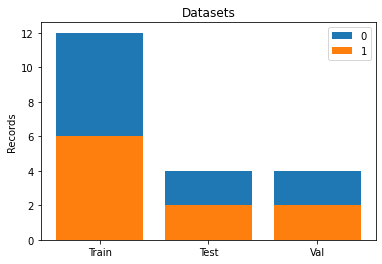

In [27]:
def split_dataframe(
    dataset: pd.DataFrame,
    target: str = 'match',
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 5,
) -> typing.Tuple[np.ndarray]:

    features = [column for column in dataset.columns if column != target]

    print("Predictors:", features)
    print("Predicted:", target)
    
    x: pd.DataFrame = dataset[features]
    y: pd.DataFrame = dataset[target]
    assert x.shape[0] == y.shape[0]
        
    print("X", x.shape)
    print("Y", y.shape)
    
    x_train, x_test, y_train, y_test = train_test_split(
        x,
        y,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=y,
    )
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=val_size,
        random_state=random_state,
        shuffle=True,
        stratify=y_train,
    )
    
    print("Train", x_train.shape, y_train.shape)
    print("Test", x_test.shape, y_test.shape)
    print("Val", x_val.shape, y_val.shape)

    assert x_train.shape[0] == y_train.shape[0]
    assert x_test.shape[0] == y_test.shape[0]
    assert x_val.shape[0] == y_val.shape[0]

    assert x_train.shape[1] == x_test.shape[1]
    assert x_train.shape[1] == x_val.shape[1]
    assert x_test.shape[1] == x_val.shape[1]

    assert x_train.shape[0] + x_test.shape[0] + x_val.shape[0] == x.shape[0]
    assert y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0]

    y_train: np.ndarray = y_train.values
    y_test: np.ndarray = y_test.values
    y_val: np.ndarray = y_val.values
    
    x_train: typing.List[np.array] = vec2matrix(x_train)
    x_test: typing.List[np.array] = vec2matrix(x_test)
    x_val: typing.List[np.array] = vec2matrix(x_val)

    print("Train:", x_train.shape, y_train.shape)
    print("Test:", x_test.shape, y_test.shape)
    print("Val:", x_val.shape, y_val.shape)
        
    matches: list = [
        sum(y_train == 1),
        sum(y_test == 1),
        sum(y_val == 1),   
    ]
    missmatches: list = [
        y_train.shape[0],
        y_test.shape[0],
        y_val.shape[0],   
    ]
    print("Matches:", matches, missmatches)
    assert matches != missmatches, "Too many matches!"
    assert all(matches), "Not enough matches!"
    assert all(missmatches), "Not enough missmatches!"
    labels: list = ['Train', 'Test', 'Val']
    fig, ax = plt.subplots()
    ax.bar(labels, missmatches, label='0')
    ax.bar(labels, matches, label='1')
    ax.set_ylabel('Records')
    ax.set_title('Datasets')
    ax.legend()
    plt.show()
    
    return x_train, y_train, x_test, y_test, x_val, y_val


x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(
    dataset=pd.DataFrame({"a": [np.array([1, 2, 3])] * 20, "m": [1, 0] * 10}),
    target='m',
    test_size=0.2,
    val_size=0.2,
)
assert x_train.shape == (12, 1, 3)
assert y_train.shape == (12, )
assert x_test.shape == (4, 1, 3)
assert y_test.shape == (4, )
assert x_val.shape == (4, 1, 3)
assert y_val.shape == (4, )
assert isinstance(x_train, np.ndarray)
assert isinstance(y_train, np.ndarray)
assert isinstance(x_test, np.ndarray)
assert isinstance(y_test, np.ndarray)
assert isinstance(x_val, np.ndarray)
assert isinstance(y_val, np.ndarray)

Input: (2, 2, 2)


2021-08-02 12:32:39.876062: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-02 12:32:39.876093: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-02 12:32:39.876177: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LenovoX1Carbon): /proc/driver/nvidia/version does not exist
2021-08-02 12:32:39.876380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 2)]            0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 4096)              20480     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              209817

2021-08-02 12:32:40.288838: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-02 12:32:40.302275: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594095000 Hz


1/1 [==============================] - 13s 13s/step - loss: 0.7030 - binary_accuracy: 0.0000e+00 - val_loss: 6.6757 - val_binary_accuracy: 0.5000
{'loss': [0.7029697299003601], 'binary_accuracy': [0.0], 'val_loss': [6.675711154937744], 'val_binary_accuracy': [0.5]}


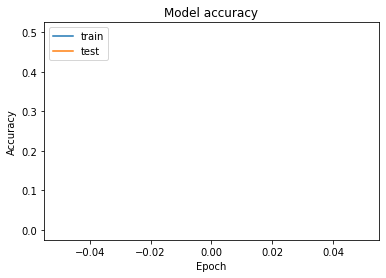

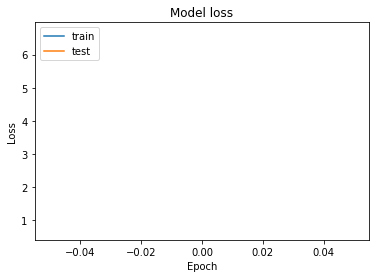

1/1 [==============================] - 0s 27ms/step - loss: 6.6757 - binary_accuracy: 0.5000
Metrics: 6.675711154937744 0.5


In [28]:
def train_find_matches(
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    x_val: np.ndarray,
    y_val: np.ndarray,
    learning_rate: float = 0.0001,
    batch_size: int = 30,
    epochs: int = 1,
    dropout: float = 0.4,
) -> typing.Tuple[keras.models.Model, float, float]:
    """
    Trains a classifier to find matches.
    """
    print("Input:", x_train.shape)
    
    input_layer: keras.layers.Input = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    flatten: keras.layers.Flatten = keras.layers.Flatten()(input_layer)

    dense1: keras.layers.Dense = keras.layers.Dense(4096, activation='relu')(flatten)
    dropout1: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense1)

    dense2: keras.layers.Dense = keras.layers.Dense(2048, activation='relu')(dropout1)
    dropout2: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense2)

    dense3: keras.layers.Dense = keras.layers.Dense(1024, activation='relu')(dropout2)
    dropout3: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense3)

    dense4: keras.layers.Dense = keras.layers.Dense(514, activation='relu')(dropout3)
    dropout4: keras.layers.Dropout = keras.layers.Dropout(dropout)(dense3)

    out: keras.layers.Dense = keras.layers.Dense(1, activation='sigmoid')(dropout4)

    model: keras.Model = keras.Model(inputs=[input_layer, ], outputs=out)

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy()
        ],
    )

    print(model.summary())
    
    history: keras.callbacks.History = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        ]
    )

    print(history.history)

    # Summarize history of accuracy.
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Summarize history for loss.
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    loss, accuracy = model.evaluate(x_val, y_val, batch_size=128)
    print("Metrics:", loss, accuracy)
    
    return model, loss, accuracy


x: np.array = np.array([[[0, 1], [0, 1]], [[0, 1], [0, 1]]])
y: np.array = np.array([0, 1])
sample_model, sample_loss, sample_accuracy = train_find_matches(
    x_train=x,
    y_train=y,
    x_test=x,
    y_test=y,
    x_val=x,
    y_val=y,
    epochs=1,
    learning_rate=0.01,
    batch_size=50,
)
assert isinstance(sample_model, keras.models.Model)
assert isinstance(sample_loss, float)
assert isinstance(sample_accuracy, float)

In [29]:
 def predict_find_matches(
    model: keras.models.Model,
    records: typing.Union[np.ndarray, list],
    threshold: typing.Optional = None,
 ) -> np.ndarray:
    """
    Uses a trained model to find matches.
    """
    if isinstance(records, list):
        records: np.ndarray = vec2matrix(df2vec(pd.DataFrame(data=records, columns=records[0].keys())))
    print("Input:", records.shape)
    predictions: list = model.predict(records)
    print("Predictions:", predictions)
    if threshold is not None:
        predictions = predictions >= threshold
        print("Threshold:", predictions)
    return predictions


assert predict_find_matches(model=sample_model, records=np.zeros((1, 2, 2))).shape == (1, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((2, 2, 2))).shape == (2, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((3, 2, 2))).shape == (3, 1)
assert predict_find_matches(model=sample_model, records=np.zeros((1, 2, 2)), threshold=0)[0][0]

Input: (1, 2, 2)
Predictions: [[0.97551405]]
Input: (2, 2, 2)
Predictions: [[0.97551405]
 [0.97551405]]
Input: (3, 2, 2)
Predictions: [[0.9755141]
 [0.9755141]
 [0.9755141]]
Input: (1, 2, 2)
Predictions: [[0.97551405]]
Threshold: [[ True]]


/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00         1
        True       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



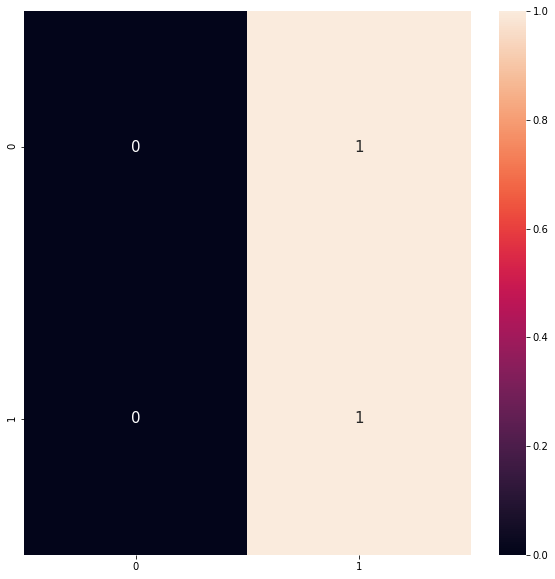

In [71]:
def error_analysis(
    model: keras.models.Model,
    x_test: np.array,
    y_test: np.array,
    threshold: float
) -> None:
    """
    Performs error analysis on a prediction model.
    """
    y_pred: np.ndarray = np.array(model.predict(x_test))
    matrix = confusion_matrix(y_test > threshold, y_pred > threshold)
    print(classification_report(y_test > threshold, y_pred > threshold))
    cm = confusion_matrix(y_test > threshold, y_pred > threshold)
    cm = pd.DataFrame(cm, range(2),range(2))
    plt.figure(figsize = (10,10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 15})
    plt.show()
    
assert error_analysis(
    model=sample_model,
    threshold=0.3,
    x_test=np.array([[[0, 1], [0, 1]], [[0, 1], [0, 1]]]),
    y_test=np.array([0, 1]),
) is None

# Companies Find Matches

There is a dataset with the distinct list of Companines and another dataset with biased feedback introduced by Users and/or Data Scientists that indicates whether 2 records represent the same Company. The dataset is processed with Pandas and vectorized with SpaCy to generate an `n` by `16` by `96` 3D Numpy Matrix. It is used as input of a Neural Network using Keras to generate a prediction model, which is uploaded to AWS S3.

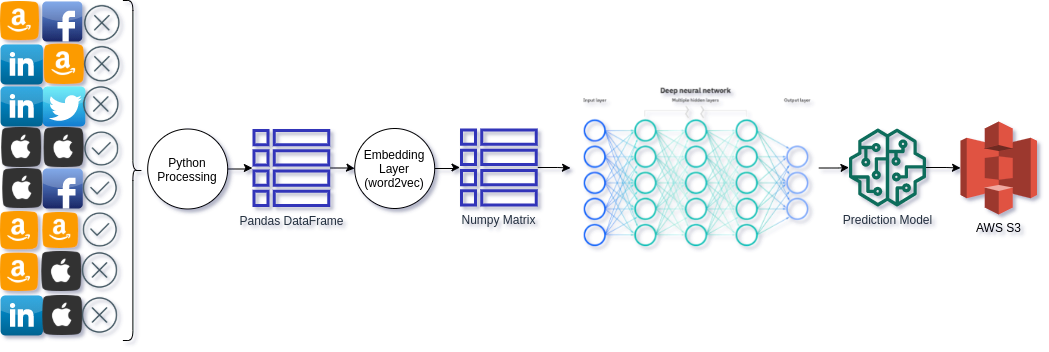

Companies: (10001, 17)


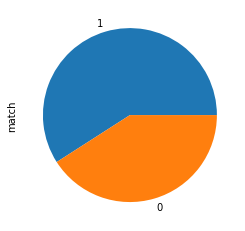

In [90]:
raw_companies_dataframe: pd.DataFrame = generate_random_companies(
    total=10000,
    nulls=.04,
    mutability=.05,
    matches=.6,
    feedback=[
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "company_name": "Airbnb",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "website": "www.airbnb.com",
                "linkedin_url": "https://www.linkedin.com/u/airbnb",
                "facebook_url": "https://www.facebook.com/user/airbnb",
            },
            {
                "city": "San Francisco",
                "country": "USA",
                "company_name": "airbnb",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "website": "www.airbnb.com.ar",
                "linkedin_url": "https://www.linkedin.com/u/airbnb",
                "facebook_url": "https://www.facebook.com/user/airbnb",
            },
            1
        )
    ]
)

In [91]:
raw_companies_dataframe.head(10)

,city#1,country#1,company_name#1,phone#1,street_address#1,website#1,linkedin_url#1,facebook_url#1,city#2,country#2,company_name#2,phone#2,street_address#2,website#2,linkedin_url#2,facebook_url#2,match
0,San Francisco,USA,Airbnb,120-403-4032,960 Air Ave.,www.airbnb.com,https://www.linkedin.com/u/airbnb,https://www.facebook.com/user/airbnb,San Francisco,USA,airbnb,120-403-4032,960 Air Ave.,www.airbnb.com.ar,https://www.linkedin.com/u/airbnb,https://www.facebook.com/user/airbnb,1
1,Nlumrpol,Mes Mrrs,Eiarceltsmop Nortclemaami,543-152-6495,"713 Jaicng Acio, Eclo St.",,www.linkedin.com/u/uieeorom,https:///www.facebook.com/profile/rricaaao,,,Eakocrlsonr Gicedmaltttc,,"181 Iupa Iaoma, Arpcog Av.",www.saaieegtrmupio.org,www.linkedin.com/u/ieeiomnpng,https:///www.facebook.com/profile/orregoeuaautru,0
2,Upimol,Cao Oesa,Ucaoacrreps Uaugwroe,865-936-5232,"922 Ustlmgoi Iotni, Ioilm Av.",www.ipuitorier.net,www.linkedin.com/u/tgruasrpws,https:///www.facebook.com/profile/inuebtreiste,ppimolu,Cao Oesa,Ucaoarrreps Uaugwroe,865-9l6-5232,"92g Ustlmgoi Iotni, Itilu Av.",www.ipuitorier.net,www.linkenin.com/u/tgruasrpssc,https:///www.facebook.com/profilu/inuebtreiste,1
3,Msrnpi Zaa,Rmhorlupt,Otoaeeglgn Tuotqeosr,352-777-7495,"460 Esmreu Imgj, Oior Av.",www.ioecmmoa.net,www.linkedin.com/u/eouoiceelloa,https:///www.facebook.com/profile/ibctpiagter,Msrnpi Zaa,Rmhorlupe,OtoaeeglgngTuotieosr,352-777-h495,"4s0 Esmreu Imgj, Oior sva",www.ioecmmoatset,www.linkedin.com/u/eouoiceelloa,https:///www.facebook.com/profile/ibctprpoter,1
4,Grapretp,Eslen Ktai,Magoeeggnuoc Mrsoteipn,636-398-9784,"895 Sior Saol, Ulesa St.",www.liumepdqiaeunt.com,www.linkedin.com/u/opiugiorurc,https:///www.facebook.com/profile/oiagizueoulij,Gmapretp,Eslen Ktai,Magoeeggnuoc Mrsoteipn,636-398-978p,"895 Sior Saol, Ulosa St.",www.liumepuqiaeunt.com,wwwrlingedin.com/u/opiugiorurc,https:///lww.facebook.com/profile/oiagizueoulij,1
5,Uiogil Ragt,Oraturino,Enmitrirglrl Oumlrrvnc,625-276-2661,"775 Drpaanoa Ioiics, Uapat Av.",www.uetetcntpi.org,www.linkedin.com/u/poirizga,https:///www.facebook.com/profile/teexoneatrir,Enelgnise,Iumutmrpgeo,Esmeeilunc Iuscmitpemi,776-385-9883,"309 Uor Penae, Cisrmt St.",www.ipiurkaicrt.com,www.linkedin.com/u/tuupaaumhl,https:///www.facebook.com/profile/gltoumuti,0
6,Atsunasro,Mtetmrmir,Pgpearoep Glasrsnuc,175-153-8359,"940 Oni Aurcs, Oseups Av.",www.pauiutetu.com,www.linkedin.com/u/torrruaieemric,https:///www.facebook.com/profile/riocciqusu,Atsunasro,Mtetmrmir,igpearoep olasrsnui,1sa-153-8359,940 Oni Aurcsp Oseups Av.,www.pauiutetu.com,www.linkedin.com/u/toirruaieemric,https:///www.facebook.com/profile/rlocciqusu,1
7,Rimci Oeg,Rmnacuogio,Rtepreuec Nuiacniuua,143-565-2260,"295 Otuuii Oatr, Gmclp St.",www.oiamialcmso.com,www.linkedin.com/u/nmraucieilcpuga,https:///www.facebook.com/profile/inuasarsuetecl,Rimci Oeg,Rmnacuogio,Rtepoeuec Nuiacniuua,143-565-2260,"295 Otuuii Oatr, Gmclp St.",www.oiamialcmso.com,www.tinkedin.com/ulnmraucieilcpuge,hrtps:///www.facebook.com/profile/inuasgrsuetecl,1
8,Lcxoeo Iru,Gbgnrpu,Oaesaacmu Ueirnicme,991-897-8420,"992 Alsinee Laemui, Orluc St.",www.elulopipiig.com,www.linkedin.com/u/omgcaiuic,https:///www.facebook.com/profile/anosicppelae,Lcxoeo Iru,Gbgnrpu,Oaesaacmu qeirnicme,991-897-8420,"992 Alsinee naemum, Orluc Stg",www.elulopipiig.com,www.linkedin.cem/u/omgcaiuic,https:///www.facabookecom/profile/anosicppelae,1
9,Ouk Luer,Ihprdw Alt,Amuorocaper Treemlrlge,861-455-5185,"194 Troriot Etame, Otestn St.",www.iiocenoorscuo.org,www.linkedin.com/u/oslmuerrpxl,https:///www.facebook.com/profile/iriuuaprirluom,Ouk Luer,Ihprpw Al,Amuorocaper Treemlrlge,861-455-51e5,"194 Troriot Elame, Otestn St.",www.iiocenoorscuo.org,www.liepedin.roa/u/onlmuertpxl,https:/o/www.facebook.com/profile/iriuuaprirouom,1


In [ ]:
vectorized_companies_dataframe: pd.DataFrame = df2vec(raw_companies_dataframe)

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: company_name#1
Vectorizing: phone#1
Vectorizing: street_address#1


In [35]:
vectorized_companies_dataframe.head(10)

,city#1,country#1,company_name#1,phone#1,street_address#1,website#1,linkedin_url#1,facebook_url#1,city#2,country#2,company_name#2,phone#2,street_address#2,website#2,linkedin_url#2,facebook_url#2,match
0,"[0.23144814, -0.30145591, 0.6764038, -0.183723...","[0.2821161, -0.7009262, -0.8047602, -0.0624053...","[-0.052118793, -0.6043631, -0.2964257, 0.08823...","[-0.03967932, 0.89339954, 0.05904472, -0.64557...","[0.05933188, 0.0023268275, 0.41789946, 0.46718...","[0.6559546, 0.6924792, -0.021584326, 0.1563281...","[-0.7291573, -0.6588761, 0.32307172, -0.239040...","[-0.6086001, 0.12302818, 0.14612034, 0.1075362...","[0.23144814, -0.30145591, 0.6764038, -0.183723...","[0.2821161, -0.7009262, -0.8047602, -0.0624053...","[-0.34143084, -0.34596783, 0.17424786, 0.16139...","[-0.03967932, 0.89339954, 0.05904472, -0.64557...","[0.05933188, 0.0023268275, 0.41789946, 0.46718...","[-0.23050725, -0.35236666, -0.57875764, 0.1572...","[-0.7291573, -0.6588761, 0.32307172, -0.239040...","[-0.6086001, 0.12302818, 0.14612034, 0.1075362...",1
1,"[-0.2352735, -0.6878431, -0.383236, -0.2628462...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.058441408, -0.24626876, 0.6989607, 0.21328...","[0.26273257, 0.59460366, 0.12031479, -0.491155...","[0.025225768, -0.40061098, 0.32453865, 0.08770...","[1.2475382, -0.21716194, 0.41874284, 0.0930631...","[0.19363487, -0.9030119, 0.48582336, -0.393683...","[0.37352443, 0.4050795, 0.29554838, -0.1690421...","[-0.048854485, -0.6475014, -0.5113186, 0.61068...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.058441408, -0.24626876, 0.6989607, 0.21328...","[0.5293634, 0.89129466, 0.24445106, 0.01599562...","[0.025225768, -0.40061098, 0.32453865, 0.08770...","[1.2475382, -0.21716194, 0.41874284, 0.0930631...","[0.19363487, -0.9030119, 0.48582336, -0.393683...","[0.5621197, 0.82189053, 0.2515829, -0.25047004...",1
2,"[-0.49356455, -0.58294386, -0.043530747, -0.13...","[-0.03328909, -0.8046761, 0.22397459, 0.289991...","[-0.72411156, -0.13245279, 0.22755182, -0.0797...","[0.15748866, 0.4927352, 0.18178716, -0.4572551...","[-0.18715549, -0.3792875, 0.30171335, -0.14068...","[0.20565969, 0.58759016, -0.9038802, 0.5845316...","[0.28092593, 0.44774812, -0.93102217, 0.384982...","[0.48014918, 0.31732756, 0.25822204, -0.242557...","[-0.005184315, -0.23798576, 0.48639604, -0.154...","[0.050042503, 0.0044698343, -0.1052028, 0.0543...","[0.004478872, -0.4579818, 0.23900929, 0.038887...","[0.43349496, 0.45960417, 0.38761207, -0.569099...","[-0.17075154, -0.18234345, 0.4706169, -0.09533...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.18606275, -0.06384203, -1.3065636, -0.2630...","[0.49144387, 0.19042608, 0.6036774, -0.1378676...",0
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.2384102, 0.005262561, -0.1120892, -0.28867...","[0.31447494, -0.45554286, 0.13465586, 0.286040...","[0.20009518, 0.33161044, 0.3379301, -0.4944211...","[-0.20653398, -0.5601099, 0.4185096, -0.222792...","[-0.45221692, 0.025060784, 0.73069084, -0.2724...","[-0.062026724, -1.1946615, 0.4001254, -0.16591...","[0.4360884, 0.43336907, 0.42741948, -0.3317486...","[-0.9758316, -0.27736205, -0.66458416, -0.3511...","[-0.16408028, -0.38810056, -0.3699636, 0.20964...","[0.24036315, -0.8425983, 0.83091664, 0.1326015...","[0.21871552, 0.4739011, 0.18763416, -0.8118889...","[-0.17932759, -0.3928454, 0.41899312, -0.39460...","[0.9630441, 0.0733251, -0.48860526, 0.1202966,...","[0.0019952059, -0.8573315, 0.6326315, -0.07440...","[0.3038029, 0.45074987, 0.2839703, -0.18073884...",0
4,"[-0.4290774, -0.65134716, -0.8546631, 0.117662...","[0.2218264, -0.040575966, 0.08629003, 0.071295...","[0.25571278, -0.23324361, 0.24393061, 0.064919...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.17386709, -0.27429712, -0.8014842, -0.1683...","[0.43112952, 0.44442263, 0.4508596, -0.2559728...","[-0.4290774, -0.65134716, -0.8546631

Predictors: ['city#1', 'country#1', 'company_name#1', 'phone#1', 'street_address#1', 'website#1', 'linkedin_url#1', 'facebook_url#1', 'city#2', 'country#2', 'company_name#2', 'phone#2', 'street_address#2', 'website#2', 'linkedin_url#2', 'facebook_url#2']
Predicted: match
X (1001, 16)
Y (1001,)
Train (640, 16) (640,)
Test (201, 16) (201,)
Val (160, 16) (160,)
Train: (640, 16, 96) (640,)
Test: (201, 16, 96) (201,)
Val: (160, 16, 96) (160,)
Matches: [264, 83, 66] [640, 201, 160]


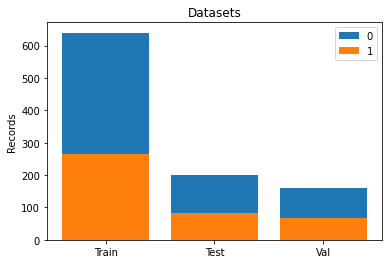

In [36]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(dataset=vectorized_companies_dataframe)

Input: (640, 14, 96)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 14, 96)]          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 4096)              5509120   
_________________________________________________________________
dropout_12 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 10

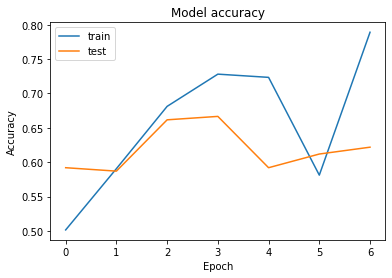

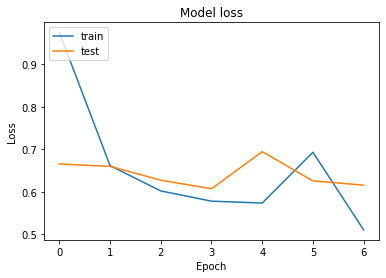

2/2 [==============================] - 0s 25ms/step - loss: 0.6178 - binary_accuracy: 0.6500
Metrics: 0.6177574396133423 0.6499999761581421


In [88]:
company_matches_model, loss, accuracy = train_find_matches(
    x_train,
    y_train,
    x_test,
    y_test,
    x_val,
    y_val,
    learning_rate=0.0001,
    epochs=30,
    batch_size=200,
    dropout=0.4,
)

              precision    recall  f1-score   support

       False       0.61      1.00      0.76       118
        True       1.00      0.08      0.16        83

    accuracy                           0.62       201
   macro avg       0.80      0.54      0.46       201
weighted avg       0.77      0.62      0.51       201



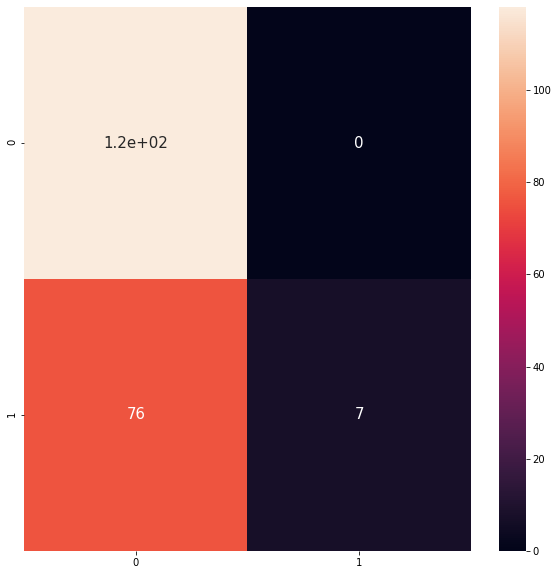

In [89]:
error_analysis(
    model=company_matches_model,
    threshold=0.5,
    x_test=x_test,
    y_test=y_test,
)

In [40]:
predictions: list = predict_find_matches(
    model=company_matches_model, 
    records=[{
        # Company 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "company_name#1": "Airbnb",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "website#1": "www.airbnb.com",
        "linkedin_url#1": "https://www.linkedin.com/u/airbnb",
        "facebook_url#1": "https://www.facebook.com/user/airbnb",
        # Company 2
        "city#2": "San Francisco",
        "country#2": "USA",
        "company_name#2": "Airbnb Inc.",
        "phone#2": "120-403-4032",
        "street_address#2": "960 Air Ave.",
        "website#2": "www.airbnb.com",
        "linkedin_url#2": "https://www.linkedin.com/u/airbnb",
        "facebook_url#2": "https://www.facebook.com/user/airbnb",
    }, {
        # Company 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "company_name#1": "Airbnb",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "website#1": "www.airbnb.com",
        "linkedin_url#1": "https://www.linkedin.com/u/airbnb",
        "facebook_url#1": "https://www.facebook.com/user/airbnb",
        # Company 2
        "city#2": "Mexico",
        "country#2": "Mexico",
        "company_name#2": "Taco Bell",
        "phone#2": "543-543-1231",
        "street_address#2": "50 Something St.",
        "website#2": "www.taco-bell.com",
        "linkedin_url#2": "https://www.linkedin.com/u/taco",
        "facebook_url#2": "https://www.facebook.com/user/taco",       
    }],
    threshold=0.5,
)
assert predictions[0][0]
assert not predictions[1][0]

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: company_name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: website#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: company_name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: website#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Input: (2, 16, 96)
Predictions: [[0.39952832]
 [0.45879665]]
Threshold: [[False]
 [False]]


AssertionError: 

# Persons Find Matches

Persons: (1001, 15)


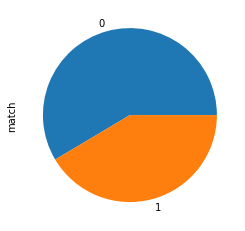

In [77]:
raw_persons_dataframe: pd.DataFrame = generate_random_persons(
    total=1000,
    nulls=.05,
    mutability=.05,
    matches=.4,
    feedback=[
        (
            {
                "city": "San Francisco",
                "country": "USA",
                "name": "John Connor",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "linkedin_url": "https://www.linkedin.com/u/john.connor",
                "facebook_url": "https://www.facebook.com/user/john.connor",
            },
            {
                "city": "San Francisco",
                "country": "USA",
                "name": "John Conor",
                "phone": "120-403-4032",
                "street_address": "960 Air Ave.",
                "linkedin_url": "https://www.linkedin.com/u/john.connor",
                "facebook_url": "https://www.facebook.com/user/john.connor",
            },
            1
        )
    ]
)

In [78]:
raw_persons_dataframe.head(10)

,city#1,country#1,name#1,phone#1,street_address#1,linkedin_url#1,facebook_url#1,city#2,country#2,name#2,phone#2,street_address#2,linkedin_url#2,facebook_url#2,match
0,Brugr Ogccn,Taepi Erug,Ieiglggp Plmualneoot,933-879-9565,"872 Euurn Gcmopj, Ieipug St.",www.linkedin.com/u/rgatneoaumzcce,https:///www.facebook.com/profile/soaocouiptatu,,Uoc Rapp,Stggtrlo Rsggmuoj,804-968-6584,"439 Lnaaoio Piulr, Eeus St.",www.linkedin.com/u/aoaorruatn,https:///www.facebook.com/profile/eruuoseuungniio,0
1,Nagam Lcarin,Eou Cee,Nsrouigirm Rppaosit,321-322-8980,"112 Ilsra Pnue, Riio St.",www.linkedin.com/u/igougohrer,https:///www.facebook.com/profile/gciggupemlsuoef,Nagam Lcarin,Eou Cee,Nsrouigirmarppeosst,321-322-8980,"112 Ilsra Pnue, Riio St.",www.linkedhn.com/u/igougohrer,https:p//www.faceoook.com/profile/gciggupemlsuoef,1
2,Opris Nig,Yomirrlui,Tuppjlgiuntc Icceozemn,743-783-5660,"37 Uicrtill Gleel, Ttproa Av.",www.linkedin.com/u/sgeoieieorou,https:///www.facebook.com/profile/raageltitane,Esgioe Rom,Ygasmzupll,Mseneuacc Uatslaimesel,747-112-4602,"234 Oual Icouuc, Muac St.",www.linkedin.com/u/oraeecarsrper,https:///www.facebook.com/profile/oeocoiso,0
3,Rmuizc Paem,Usulmolum,Uiwsatpmp Saleampemorf,400-812-1999,"962 Olnrnmai Iadie, Pooni St.",www.linkedin.com/u/mlooionan,https:///www.facebook.com/profile/itccryoiiae,Uaen Tom,,Uopmcmfmaug Eacammpoicoe,660-672-1902,,www.linkedin.com/u/aqsriurstudll,https:///www.facebook.com/profile/ilolnoercaorrue,0
4,Jautouoipr,Rep Rai,Iegttumiuaon Xcipuiiaap,349-749-3483,"637 Tstrsgv Eorn, Umper St.",www.linkedin.com/u/karrtgnisriiru,https:///www.facebook.com/profile/prmgaeiein,Racmrr Lruan,Etttpasaa,Poucsuuuepis Eeloeeoepeer,897-498-1593,"263 Purtalit Ouipul, Aamp Av.",www.linkedin.com/u/eopraorre,https:///www.facebook.com/profile/simssugs,0
5,Eigeoeegol,Aeeeelso,Aosimuaanpca Eacroioi,,"992 Eaoui Ecare, Asiog Av.",www.linkedin.com/u/grpnosruudoaco,https:///www.facebook.com/profile/luiareriuriora,Rimgpouir,,Leparuomiiou Untgeilsoeg,863-818-7148,"128 Outslr Suaibu, Pceoi St.",www.linkedin.com/u/iuuouumuutaauri,https:///www.facebook.com/profile/ntpcnamo,0
6,,Qlgsoio,Dprmhpsem Rinnmmeesi,653-272-2713,"867 Saozp Urica, Oceocl St.",,https:///www.facebook.com/profile/ciuuuugggazrrs,Mirurbiil,Lniranpu,Eesigoic Srpameraer,491-191-5338,"97 Aure Eatr, Pnioes St.",www.linkedin.com/u/iurrcritoso,,0
7,Orcrsuar,Isgu Aes,Oiriesnmau Angacuor,322-394-5474,"243 Ploqr Elnrur, Lwerrt St.",www.linkedin.com/u/trnreenhjir,https:///www.facebook.com/profile/daglepelura,Ecaelprleeo,Ueniraamre,Zouosroeg Rasueluofoi,102-906-3663,"933 Sea Osone, Cppo St.",www.linkedin.com/u/seliuonuiir,https:///www.facebook.com/profile/aranrapnos,0
8,Mnhrca Ucpa,Ipnorisepa,Geieeuocsiu Ueiiouoo,247-481-2090,"91 Cac Geao, Aipgol Av.",www.linkedin.com/u/puauiromumllui,https:///www.facebook.com/profile/epactotvue,Mnhrca Ucpa,Ipnorisrpa,Geieeuocsiu Uoiiouoo,247-481-2090,"91 Cac Geao, Aipgol Av.",www.linkedin.czm/u/puauiiomumllui,https:///www.facebook.com/prafile/epactotvue,1
9,Pleinpp,Iro Igeiua,Oihupnua Lerpxspgo,982-287-5330,"704 Elclrinp Oieaeo, Upfoo St.",www.linkedin.com/u/uvrgeanr,https:///www.facebook.com/profile/rciearurmos,Pleinpn,Iro Igeieb,Oihupnua Lermxspg,982-e87-5330,"7s4 Elclriip Oieaeo, UafoooSt.",www.linkedin.com/u/uvrgeanr,https:///www.facebook.com/profile/rciearurmos,1


In [79]:
vectorized_persons_dataframe: pd.DataFrame = df2vec(raw_persons_dataframe)

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Vectorizing: match


In [80]:
vectorized_persons_dataframe.head(10)

,city#1,country#1,name#1,phone#1,street_address#1,linkedin_url#1,facebook_url#1,city#2,country#2,name#2,phone#2,street_address#2,linkedin_url#2,facebook_url#2,match
0,"[0.075330496, -0.4067589, -0.23451754, 0.74601...","[-0.38455915, -0.33186287, 0.7999415, 0.012197...","[-0.020889342, -0.4438734, 0.08915196, -0.2310...","[0.108879164, 0.3596379, 0.27443573, -0.647967...","[-0.07455264, -0.18856807, 0.47951818, -0.1844...","[0.119056165, -0.7242446, 0.27029133, 0.103051...","[0.3424983, 0.28291398, 0.41641912, -0.2332893...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.13330966, -0.57418144, 0.6096692, 0.160988...","[0.38339758, -0.6694581, 0.620679, -0.03332063...","[0.2130642, 0.66228426, 0.21856232, -0.5450543...","[-0.23429321, -0.72451764, 0.38725317, -0.3800...","[-0.6683244, -0.34210163, 0.19567057, -0.47859...","[0.4042549, 0.41283792, 0.29084417, -0.2068459...",0
1,"[-0.042908933, -0.48434603, 0.3039111, 0.16750...","[0.09003791, -0.28758633, -0.25440288, 0.18256...","[-0.08693943, -0.7576142, 0.4151153, -0.101073...","[0.2527148, 0.2621278, 0.08079307, -0.51311487...","[-0.066793, -0.59758085, 0.41497648, -0.376335...","[0.51919746, 0.98247427, 0.18622655, 0.2252153...","[0.39500594, 0.3613201, 0.5543092, -0.3190463,...","[-0.042908933, -0.48434603, 0.3039111, 0.16750...","[0.09003791, -0.28758633, -0.25440288, 0.18256...","[-0.048031002, -0.21048303, 1.0579239, 0.23181...","[0.2527148, 0.2621278, 0.08079307, -0.51311487...","[-0.066793, -0.59758085, 0.41497648, -0.376335...","[-0.092650995, -0.31651583, 0.0086738765, 0.20...","[-0.09366875, -0.025889413, 0.64062124, -0.239...",1
2,"[0.0008814186, -0.41155759, 0.08273175, -0.066...","[-0.6060178, 0.36308885, -0.61292875, 0.393365...","[0.2115486, -0.2582811, 0.59979755, 0.10900506...","[0.4226173, 0.86043036, 0.008443308, -0.638505...","[-0.15116075, -0.34179527, 0.4071538, -0.09239...","[0.4269531, -0.296566, 0.1814943, 0.106194064,...","[0.43728876, 0.45705867, 0.46290392, -0.289339...","[0.13813275, 0.20506918, 0.22110583, 0.1730720...","[-0.1639958, -0.62969315, 0.10372841, 0.957370...","[-0.11823648, -0.4561679, -0.18370627, 0.25777...","[0.03657081, 0.5357677, 0.038669348, -0.552416...","[-0.07586212, -0.3577075, 0.18984763, -0.28573...","[0.07954207, -0.6952197, -0.41225246, -0.67676...","[0.39976296, 0.43391877, 0.20850706, -0.124993...",0
3,"[0.21107474, -0.7366403, -0.1269823, 0.3528378...","[-0.35651362, -0.7291849, -0.21697707, 0.23171...","[-0.47846788, 0.36977968, 0.1606364, 0.0032185...","[0.22114758, 0.4148418, 0.12187718, -0.6014578...","[-0.15911664, -0.45888725, 0.47821403, -0.2888...","[-0.039108604, -0.08622201, -0.15551184, 0.265...","[0.4491914, 0.31584066, 0.24001975, -0.3493817...","[0.5164305, -0.9938095, -0.1295794, -0.2040467...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.13942698, -0.23480628, 0.4499402, -0.02867...","[0.34644142, 0.31203908, 0.22014594, -0.570949...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0006969422, -0.5223172, -0.45379114, -0.39...","[0.21946797, 0.3028156, 0.18749152, -0.1593377...",0
4,"[-0.4110864, -0.80312335, -0.4229336, 0.306552...","[-0.18016513, -0.51660836, -0.00022923946, 0.0...","[-0.27205747, -0.72514164, 0.10934525, 0.36092...","[0.17618416, 0.85056275, 0.12862127, -0.702407...","[-0.08846898, -0.2145201, 0.324832, -0.3436526...","[0.5824579, 0.08215368, -0.24765548, 0.1651894...","[0.44653377, 0.23434666, 0.34024048, -0.243484...","[-0.607683, -0.29741445, 0.4854469, 0.18489628...","[-0.19008893, -0.9098931, 0.4007367, -0.379550...","[0.029437155, -0.13941942, 0.58308464, -0.2939...","[0.403866, 0.5368853, 0.2071071, -0.5040545, -...","[-0.06521924, -0.3343841, 0.30663803, -0.03304...","[0.2114799, 0.01273796, -0.26043177, -0.240242...","[0.37033314, 0.5401429, 0.1691005, -0.3004381,...",0
5,"[-0.5234222, -0.7612805, -0.57378244, 0.013924...","[-1.0604491, -0.6688432, -0.33324742, 0.148464...","[-0.24218845, -0.70738745, 0.15488593, 0.45931...","[0.0, 0.0, 0.0, 

Predictors: ['city#1', 'country#1', 'name#1', 'phone#1', 'street_address#1', 'linkedin_url#1', 'facebook_url#1', 'city#2', 'country#2', 'name#2', 'phone#2', 'street_address#2', 'linkedin_url#2', 'facebook_url#2']
Predicted: match
X (1001, 14)
Y (1001,)
Train (640, 14) (640,)
Test (201, 14) (201,)
Val (160, 14) (160,)
Train: (640, 14, 96) (640,)
Test: (201, 14, 96) (201,)
Val: (160, 14, 96) (160,)
Matches: [266, 83, 66] [640, 201, 160]


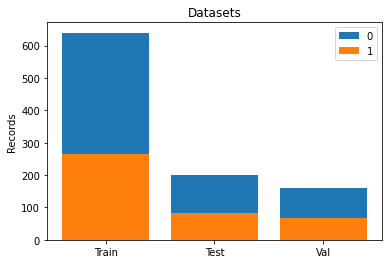

In [81]:
x_train, y_train, x_test, y_test, x_val, y_val = split_dataframe(dataset=vectorized_persons_dataframe)

Input: (640, 14, 96)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 14, 96)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              5509120   
_________________________________________________________________
dropout_8 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10

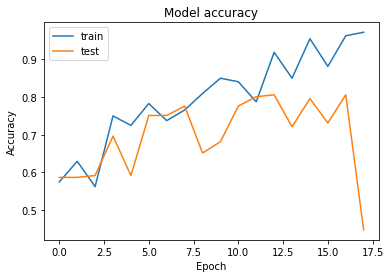

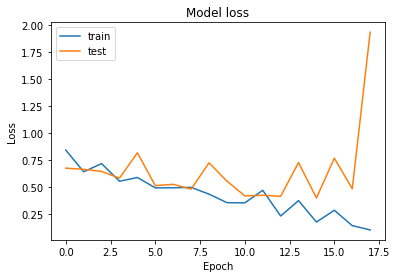

2/2 [==============================] - 0s 29ms/step - loss: 1.9661 - binary_accuracy: 0.4375
Metrics: 1.9661357402801514 0.4375


In [82]:
persons_matches_model, loss, accuracy = train_find_matches(
    x_train,
    y_train,
    x_test,
    y_test,
    x_val,
    y_val,
    learning_rate=0.0001,
    epochs=50,
    batch_size=100,
    dropout=0.4,
)

              precision    recall  f1-score   support

       False       1.00      0.06      0.11       118
        True       0.43      1.00      0.60        83

    accuracy                           0.45       201
   macro avg       0.71      0.53      0.36       201
weighted avg       0.76      0.45      0.31       201



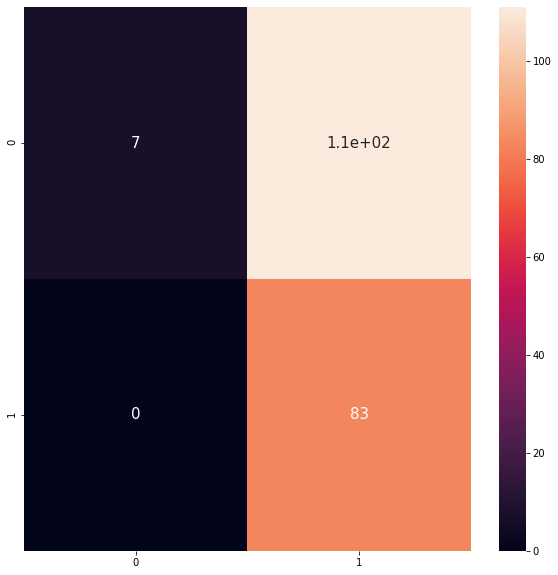

In [84]:
error_analysis(
    model=persons_matches_model,
    threshold=0.5,
    x_test=x_test,
    y_test=y_test,
)

In [83]:
predictions: list = predict_find_matches(
    model=persons_matches_model, 
    records=[{
        # Person 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "name#1": "John Connor",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "linkedin_url#1": "https://www.linkedin.com/u/john.connor",
        "facebook_url#1": "https://www.facebook.com/user/john.connor",
        # Person 2
        "city#2": "San Francisco",
        "country#2": "USA",
        "name#2": "John Conor",
        "phone#2": "120-403-4032",
        "street_address#2": "960 Air Ave.",
        "linkedin_url#2": "https://www.linkedin.com/u/john.connor",
        "facebook_url#2": "https://www.facebook.com/user/john.connor",
    }, {
        # Person 1
        "city#1": "San Francisco",
        "country#1": "USA",
        "name#1": "John Connor",
        "phone#1": "120-403-4032",
        "street_address#1": "960 Air Ave.",
        "linkedin_url#1": "https://www.linkedin.com/u/john.connor",
        "facebook_url#1": "https://www.facebook.com/user/john.connor",
        # Person 2
        "city#2": "Mexico",
        "country#2": "Mexico",
        "name#2": "Terminator",
        "phone#2": "543-342-9594",
        "street_address#2": "120 Terminator St.",
        "linkedin_url#2": "https://www.linkedin.com/u/terminator",
        "facebook_url#2": "https://www.facebook.com/user/terminator",    
    }],
    threshold=0.5,
)
assert predictions[0][0]
assert not predictions[1][0]

Vectorizing: city#1
Vectorizing: country#1
Vectorizing: name#1
Vectorizing: phone#1
Vectorizing: street_address#1
Vectorizing: linkedin_url#1
Vectorizing: facebook_url#1
Vectorizing: city#2
Vectorizing: country#2
Vectorizing: name#2
Vectorizing: phone#2
Vectorizing: street_address#2
Vectorizing: linkedin_url#2
Vectorizing: facebook_url#2
Input: (2, 14, 96)
Predictions: [[0.9963552]
 [0.9999957]]
Threshold: [[ True]
 [ True]]


AssertionError: 